In [1]:
from katsu.polarimetry import full_mueller_polarimetry
from katsu.mueller import linear_polarizer,linear_retarder,linear_diattenuator
import numpy as np

# Dual Rotating Retarder Mueller Polarimetry
The dual rotating retarder polarimeter is an instrument capable of measuring the full mueller matrix of a given sample. This device has seen fairly widespread use for optical component characterization because of it's ease of implementation and use.

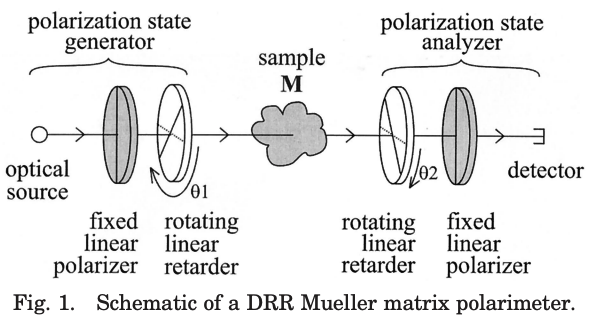

The theory of this polarimeter is covered in Chipman [1], and also Azzam [2], but is reproduced in brief here. Our first polarizer/waveplate pair forms our *polarization state generator* (PSG). The latter pair forms our *polarization state analyzer* (PSA). The first waveplate must rotate $N_{meas} > 16$ times at some angular step size $\delta\theta$. The second waveplate must also rotate $N_{meas}$ times, but at five times the step size $5\delta\theta$.

For each $\delta\theta$ we record the power on the detector. We next must understand that detectors can only measure power! This means, that it effectively measures the first row of the PSA matrix and the first column of the PSG matrix.

$$\mathbf{S}_{out} = [\mathbf{PSA}] \mathbf{M}_{system} [\mathbf{PSG}] \mathbf{S_{0}}$$

For each measurement iteration we compute our PSA and PSG, and then store those results in our polarimetric data reduction matrix $\mathbf{W}$. This is an $N_{meas} \times 16$ matrix that contains what our PSA and PSG are doing. $\mathbf{W}$ is given by:

$$\mathbf{W} = [\mathbf{PSA}_{0,j}] \otimes [\mathbf{PSG}_{i,0}]$$

Where $i,j$ are the row and column indices, respectively, and $\otimes$ is the Kronecker product. For each measurement, we record the power on the detector and store it in a vector that is $N_{meas}$ long, called $\mathbf{P}$, and we compute the unraveled mueller matrix using the following relation:

$$\mathbf{M}_{meas} = \mathbf{W}^{-1}\mathbf{P}$$

For the case where $N_{meas} > 16$, you must use the moore-penrose pseudo inverse to invert $\mathbf{W}$. For the case of the PSA/PSG being polarizer-quarter wave plate pairs, you can measure the full mueller matrix. If the waveplates are half-wave plates, then you can only measure the terms that affect the linear stokes parameters (Q,U).

## References
- [1] Chipman, Lam, & Young _Polarized Light and Optical Systems_ (2018)
- [2] Azzam, _Stokes-vector and Mueller-matrix polarimetry [Invited]_ (2016)
- [3] [2]	James Heath, Meredith Kupinski, Ewan Douglas, Kira Hart, James Breckinridge, "Mueller matrix maps of dichroic filters reveal polarization aberrations," Proc. SPIE 11443, Space Telescopes and Instrumentation 2020: Optical, Infrared, and Millimeter Wave, 1144341 (22 December 2020); https://doi.org/10.1117/12.2576282
- [4] Manxuan Zhang, Maxwell Millar-Blanchaer et al "Characterizing the Instrumental Polarization of SCExAO VAMPIRES," Proc SPIE 2023

## Simulating instrument polarimetry
Instrumental polarization and crosstalk can corrupt the measurements of polarized signals. If we can derive the Mueller matrix of our instrument, we can apply its inverse to the measured stokes parameters to recover the true polarization state of our observation. Let's start by generating a random Mueller Matrix below. This is composed of an arbitrary diattenuator and retarder. We import functions that generate linear retarder and diattenuator mueller matrices from `katsu`, which may become a full package one day.

In [2]:
# Start by generating a random mueller matrix composed of a polarizer and retarder
M_to_measure = linear_retarder(np.random.random(),np.random.random()) @ linear_diattenuator(np.random.random(),np.random.random())
display(M_to_measure)
random_retarder = linear_retarder(np.random.random(),np.random.random())
display(random_retarder)

array([[ 1.61359445,  0.31490922,  0.22392284,  0.        ],
       [ 0.27791665,  1.39671618,  0.03843271, -0.76113224],
       [ 0.22745714,  0.04138735,  1.58085848,  0.07271922],
       [ 0.14260028,  0.77525261, -0.06267864,  1.36739439]])

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.99360938, -0.00193533, -0.11285676],
       [ 0.        , -0.00193533,  0.9994139 , -0.0341775 ],
       [ 0.        ,  0.11285676,  0.0341775 ,  0.99302329]])

Next we construct a series of measurements to probe the polarization state of the light. The algorithm roughly goes like:
1) increment PSG waveplated by $\delta \theta$
2) increment PSA waveplated by $5\delta \theta$
3) compute elements of $\mathbf{W}$ using the PSG and PSA vectors
4) take a power measurement

This procedure repeats for however many measurements you need. To fill out the Mueller matrix, you need a minimum of 16, but more (say, 24) helps you filter some of the noise. The algorithm above is reproduced below in Python for those who are fluent in parseltounge.

In [3]:
# define the PSA and PSG
nmeas = 16
psa_retardance = np.pi
psg_retardance = np.pi

# set up necessary vectors
Wmat = np.zeros([nmeas,16])
Pmat = np.zeros([nmeas])

# angular increments that we rotate the waveplates
thetas = np.linspace(0,np.pi,nmeas)

# each iteration represents a measurement
for i in range(nmeas):

    # create mueller matrix of PSG, HWP angle is stepped
    Mg = linear_retarder(thetas[i],psg_retardance) @ linear_polarizer(0)

    # create mueller matrix of PSA, HWP angle is stepped - this rotates at 5 times the angular increment of the PSG
    Ma = linear_polarizer(0) @ linear_retarder(5*thetas[i],psa_retardance)

    # Polarimetric data reduction matrix
    Wmat[i,:] = np.kron(Ma[0,:],Mg[:,0])

    # simulated power observed
    Pmat[i] = Ma[0,:] @ M_to_measure @ Mg[:,0]

# polarimetric data reduction
M_measured = np.linalg.pinv(Wmat) @ Pmat
M_measured = M_measured.reshape([4,4])

How did we do?

In [4]:
display('Mueller Matrix',M_to_measure)
display('Measured Mueller Matrix',M_measured.astype(np.float32),precision)
print('-'*20)
pc_difference = (M_to_measure-M_measured) / M_to_measure * 100 
display('Percent Difference',pc_difference.astype(np.float32))

'Mueller Matrix'

array([[ 1.61359445,  0.31490922,  0.22392284,  0.        ],
       [ 0.27791665,  1.39671618,  0.03843271, -0.76113224],
       [ 0.22745714,  0.04138735,  1.58085848,  0.07271922],
       [ 0.14260028,  0.77525261, -0.06267864,  1.36739439]])

'Measured Mueller Matrix'

array([[ 1.61359441e+00,  3.14909220e-01,  2.23922834e-01,
        -3.59929280e-17],
       [ 2.77916640e-01,  1.39671624e+00,  3.84327136e-02,
        -7.62426730e-17],
       [ 2.27457136e-01,  4.13873531e-02,  1.58085847e+00,
        -1.31852722e-16],
       [ 1.17839265e-17,  2.91180356e-18,  2.65992724e-16,
        -4.73532875e-33]], dtype=float32)

--------------------


<ipython-input-4-c56bdf6e13c4>:4: RuntimeWarning: divide by zero encountered in divide
  pc_difference = (M_to_measure-M_measured) / M_to_measure * 100


'Percent Difference'

array([[ 2.75217369e-14,  1.05766009e-13, -1.36346663e-13,
                    inf],
       [ 2.19714316e-13, -1.11283324e-13, -1.45881623e-11,
         1.00000000e+02],
       [-1.22025523e-14,  1.25743014e-12,  7.02291212e-14,
         1.00000000e+02],
       [ 1.00000000e+02,  1.00000000e+02,  1.00000000e+02,
         1.00000000e+02]], dtype=float32)

## Discussion
We've illustrated the basics of DRRP's to perform direct mueller matrix measurements. Using half-wave plates, the components of the Mueller matrix that correspond to the circular components of the stokes vector are not measureable. 

**name preliminary, still thinking of a better one

## Measuring the instrumental polarization of SCExAO
The current calibration procedure for modeling instrumental polarization uses a model-based approach. While effective, I was curious about how they compare to direct measurements of the Mueller Matrix. We can't perform dual-rotating retarder polarimetry on the telescope, but we can perform it on the SCExAO testbed! The calibration source (shown in blue box below) has a linear polarizer and half wave plate that can rotate, which serves as our polarization state generator
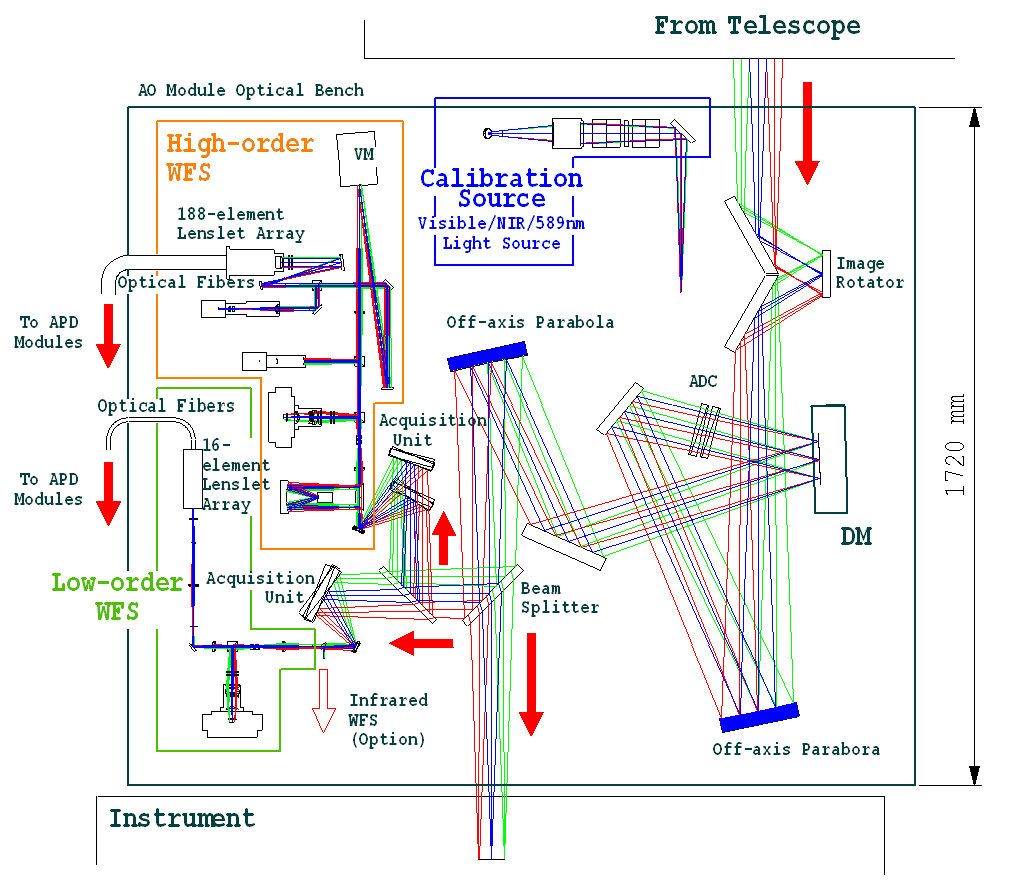
Image source: https://www.naoj.org/Observing/Instruments/AO/system.html

Our polarization state analyzer can be a combination of two optics in the VAMPIRES path
- the rotatable quarter-wave plates before the periscope (shown in red, bottom left)
- the fixed polarizing beam splitter (PBS) before the cameras (shown in green, top right)

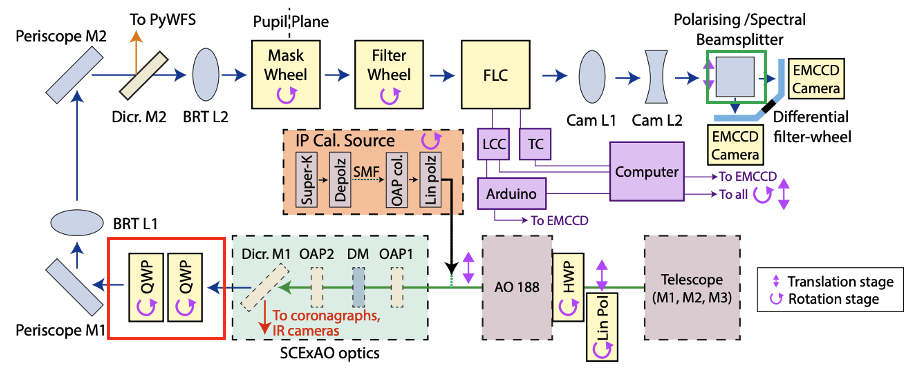
Image source: https://www.naoj.org/Projects/SCEXAO/scexaoWEB/030openuse.web/040vampires.web/2018_VAMPIRES.pdf 

**This measurement method makes the assumption that the operator on the polarization state between the QWPs and the PBS is known**, which will be inexact. However, we've taken a direct measurement of the Mueller matrix $\mathbf{M}_{AO188}$, which includes
- the image derotator
- the AO188 optics (OAPs, folds, WFS beamsplitter)
- the dichroic that separates CHARIS and VAMPIRES

The remaining optics could be measured _if_ we had a rotating retarder downstream. Given that we do not, we miss capturing the following:
- The VAMPIRES periscope
- PyWFS dichroic beamsplitter
- VAMPIRES beamsplitter stacks

And of course, we miss the influence of the observatory. However, we can compare the measured Mueller matrix to the one derived in Zhang et al [4] to examine the consistency between the two methods of determining instrumental polarization. The measured matrix can also be used to reduce the number of fitting parameters by including the effects of the AO188 optics and the image derotator, potentially minimizing the fitting error in the results. Performing this analysis in pupil-imaging mode will also allow us to assess the presence of polarization aberrations in the system.

## Test Plan
- 1. Turn on calibration source
- 2. Enable pupil-imaging mode
- 3. Choose wavelength filter (625nm or 775nm are preferable)
- 4. Set calibration source polarizer element angles
    - 4a. set polarizer to 0 degrees
    - 5b. set HWP to 0 degrees
- 5. set QWP pair angle to 0 degrees (they will rotate together)
- 6. Take a power measurement on VAMPIRES CAM1 & CAM2 with PBS in
- For $i$ in range(27) (repeat 27 times)
    - increment calibration source HWP by $\pi/27 \times i$
    - increment QWP pair angles by $5\pi/27 \times i$
    - take power measurement on VAMPIRES CAM1 & CAM2 with PBS in
